##Environment

In [1]:
import gym
from gym import spaces
import numpy as np

class CombinedAGIEnv(gym.Env):
    def __init__(self, team_size=5, s0=3.0, alpha=1.5, start_collaboration=None):
        super(CombinedAGIEnv, self).__init__()

        self.team_size = team_size
        self.max_skill = team_size
        self.s0 = s0
        self.alpha = alpha
        self.start_collaboration = start_collaboration
        self.workers = []  # Initialize with no workers

        # Action: 0=Explore, 1=Retreat, 2=CollaborateToggle, 3=Search, 4..n=Hire & Fire
        self.action_space = spaces.Discrete(4 + team_size)

        self.observation_space = spaces.Dict({
            "explore_state": spaces.Discrete(9),
            "team_skills": spaces.Box(low=0.0, high=1.0, shape=(team_size,), dtype=np.float32),
            "team_salaries": spaces.Box(low=0.0, high=1.0, shape=(team_size,), dtype=np.float32),
            "candidate": spaces.Box(low=0.0, high=1.0, shape=(2,), dtype=np.float32),
            "total_salary": spaces.Box(low=0.0, high=team_size, shape=(), dtype=np.float32),
        })

        self.terminal_states = [3, 4, 5, 6, 7, 8]
        self._define_transitions()
        self.reset()

    def _define_transitions(self):
        self.prob_transition = {
            0: {0: [{"state": 6, "prob": 0.07, "reward": 100}, {"state": 0, "prob": 0.93, "reward": -2}],
                1: [{"state": 3, "prob": 1.0, "reward": 10}],
                2: [{"state": 2, "prob": 1.0, "reward": -5}]},
            1: {0: [{"state": 7, "prob": 0.01, "reward": 100}, {"state": 1, "prob": 0.99, "reward": -1}],
                1: [{"state": 4, "prob": 1.0, "reward": 10}],
                2: [{"state": 0, "prob": 1.0, "reward": -1}]},
            2: {0: [{"state": 8, "prob": 0.015, "reward": 100}, {"state": 2, "prob": 0.985, "reward": -1}],
                1: [{"state": 5, "prob": 1.0, "reward": 10}],
                2: []},
            3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}
        }

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.state = 0 if self.start_collaboration else 1 if self.start_collaboration is not None else np.random.choice([0, 1])
        self.workers = [self._generate_worker() for _ in range(self.team_size)]
        self.candidate = self._generate_worker()
        self._update_stats()
        self.current_step = 0
        return self._get_obs(), {}

    def _generate_worker(self, skill_bias=0.5, skill_uncertainty=0.5, skill_mean=0.5, salary_noise=0.2):
        base_skill = np.clip(np.random.normal(skill_mean + skill_bias * (self._current_skill() / self.max_skill), skill_uncertainty), 0, 1)
        salary = np.clip(base_skill + np.random.normal(0.0, salary_noise), 0.0, 1.0)
        return {"skill": base_skill, "salary": salary}

    def _current_skill(self):
        return sum(w['skill'] for w in self.workers)

    def _update_stats(self):
        self.total_salary = sum(w['salary'] for w in self.workers)

    def _get_obs(self):
      skills = [w['skill'] for w in self.workers]
      salaries = [w['salary'] for w in self.workers]
      return {
          "explore_state": self.state,
          "team_skills": np.array(skills[:self.team_size], dtype=np.float32),
          "team_salaries": np.array(salaries[:self.team_size], dtype=np.float32),
          "candidate": np.array([self.candidate['skill'], self.candidate['salary']], dtype=np.float32),
          "total_salary": np.float32(self.total_salary)
      }

    def step(self, action):
      reward = 0
      done = False

      if action == 0:  # Explore
          if self.state in self.terminal_states:
              return self._get_obs(), 0, True, False, {}
          transitions = self.prob_transition.get(self.state, {}).get(0, [])
          if not transitions:
              return self._get_obs(), -10, False, False, {"error": "Invalid explore action"}
          probs = [t["prob"] for t in transitions]
          result = np.random.choice(len(transitions), p=probs)
          outcome = transitions[result]
          self.state = outcome["state"]
          reward = outcome["reward"]
          done = self.state in self.terminal_states
          if not done and np.random.rand() < self._agi_probability():
              self.state = 6 if self.state == 0 else 7 if self.state == 1 else 8
              reward += 100
              done = True

      elif action == 1:  # Retreat
          if self.state in self.terminal_states:
              return self._get_obs(), 0, True, False, {}
          transitions = self.prob_transition.get(self.state, {}).get(1, [])
          if not transitions:
              return self._get_obs(), -10, False, False, {"error": "Invalid retreat action"}
          probs = [t["prob"] for t in transitions]
          result = np.random.choice(len(transitions), p=probs)
          outcome = transitions[result]
          self.state = outcome["state"]
          reward = outcome["reward"]
          done = self.state in self.terminal_states

      elif action == 2:  # Collaborate toggle
          if self.state == 0:
              self.state = 1
              reward -= 2  # Cost to start collaboration
          elif self.state == 1:
              self.state = 2
              reward -= 5  # Penalty for breaking collaboration

      elif action == 3:  # Search for new candidate
          self.candidate = self._generate_worker()
          if np.random.rand() < self._agi_probability():
              self.state = 6 if self.state == 0 else 7 if self.state == 1 else 8
              reward += 100
              done = True
          else:
            reward-=3

      elif action >= 4:  # Hire candidate to replace team member
          fire_index = action - 4
          if 0 <= fire_index < len(self.workers):
              old_skill = self.workers[fire_index]['skill']
              self.workers[fire_index] = self.candidate
              reward += self.candidate['skill'] - old_skill
              self._update_stats()
              self.candidate = self._generate_worker()
          else:
              reward -= 10  # Invalid hire index

      # Always penalize salary maintenance
      reward -= 5 * self.total_salary / self.team_size
      self.current_step += 1
      return self._get_obs(), reward, done, False, {}

    def _agi_probability(self):
        return 1 / (1 + np.exp(-self.alpha * (self._current_skill() - self.s0)))

    def render(self):
        print(f"Step: {self.current_step} | State: {self.state} | Salary: {self.total_salary:.2f} | Skill: {self._current_skill():.2f}")
        for i, w in enumerate(self.workers):
            print(f"  Worker {i}: Skill={w['skill']:.2f}, Salary={w['salary']:.2f}")
        print(f"Candidate: Skill={self.candidate['skill']:.2f}, Salary={self.candidate['salary']:.2f}")

    def close(self):
        pass


## Deep Q Learning

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size=64):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)



def flatten_observation(obs):
    """
    Flatten a dictionary observation into a 1D float32 NumPy array.
    Handles cases where arrays may already be Python lists.
    """
    flat = [
        float(obs['explore_state']),              # Ensure scalar
        *obs['team_skills'],                      # team skills (list of floats)
        *obs['team_salaries'],                    # team salaries (list of floats)
        *obs['candidate'],                        # candidate skill/salary (list of 2 floats)
        float(obs['total_salary'])                # scalar
    ]
    return np.array(flat, dtype=np.float32)



def train_dqn(env, num_episodes=1000, gamma=0.99, lr=1e-3, batch_size=64,
              epsilon_decay=0.995, min_epsilon=0.01, target_update_freq=10):

    input_dim = len(flatten_observation(env.reset()[0]))
    output_dim = env.action_space.n

    q_net = DQN(input_dim, output_dim)
    target_q_net = DQN(input_dim, output_dim)
    target_q_net.load_state_dict(q_net.state_dict())

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer()

    epsilon = 1.0
    rewards_per_episode = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = flatten_observation(obs)
        total_reward = 0
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = q_net(torch.tensor(state).float().unsqueeze(0))
                    action = q_values.argmax().item()

            next_obs, reward, done, _, _ = env.step(action)
            next_state = flatten_observation(next_obs)

            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                q_vals = q_net(states).gather(1, actions.unsqueeze(1)).squeeze()
                with torch.no_grad():
                    next_q_vals = target_q_net(next_states).max(1)[0]
                    targets = rewards + gamma * next_q_vals * (1 - dones)

                loss = nn.MSELoss()(q_vals, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        if (episode + 1) % target_update_freq == 0:
            target_q_net.load_state_dict(q_net.state_dict())

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

    # Define the policy function
    def policy(obs_dict):
        state = flatten_observation(obs_dict)
        with torch.no_grad():
            q_values = q_net(torch.tensor(state).float().unsqueeze(0))
            action = q_values.argmax().item()
        return action

    return rewards_per_episode, q_net, policy



In [3]:
env = CombinedAGIEnv()
rewards, model, policy = train_dqn(env)

obs, _ = env.reset()
done = False
while not done:
    action = policy(obs)
    obs, reward, done, _, _ = env.step(action)
    env.render()


<ipython-input-2-a6ca5ab944de>:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(states, dtype=torch.float32),


Episode 50, Total Reward: 91.57, Epsilon: 0.778
Episode 100, Total Reward: 74.92, Epsilon: 0.606
Episode 150, Total Reward: 95.79, Epsilon: 0.471
Episode 200, Total Reward: 82.27, Epsilon: 0.367
Episode 250, Total Reward: 95.19, Epsilon: 0.286
Episode 300, Total Reward: 5.81, Epsilon: 0.222
Episode 350, Total Reward: 96.92, Epsilon: 0.173
Episode 400, Total Reward: 95.41, Epsilon: 0.135
Episode 450, Total Reward: 94.97, Epsilon: 0.105
Episode 500, Total Reward: 95.73, Epsilon: 0.082
Episode 550, Total Reward: 95.12, Epsilon: 0.063
Episode 600, Total Reward: 96.35, Epsilon: 0.049
Episode 650, Total Reward: 88.30, Epsilon: 0.038
Episode 700, Total Reward: 94.76, Epsilon: 0.030
Episode 750, Total Reward: 91.77, Epsilon: 0.023
Episode 800, Total Reward: 94.34, Epsilon: 0.018
Episode 850, Total Reward: 89.99, Epsilon: 0.014
Episode 900, Total Reward: 97.27, Epsilon: 0.011
Episode 950, Total Reward: 94.66, Epsilon: 0.010
Episode 1000, Total Reward: 84.19, Epsilon: 0.010
Step: 1 | State: 0 | 

## Visualization

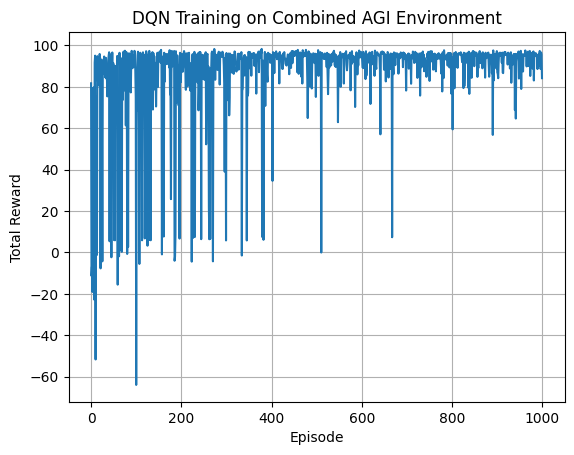

In [4]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training on Combined AGI Environment")
plt.grid(True)
plt.show()


In [5]:
def visualize_policy_heatmap(policy_net, env, num_skills=20):
    skill_range = np.linspace(0, 1, num_skills)
    collab_states = [0, 1]
    action_map = np.zeros((len(collab_states), len(skill_range)))

    for i, collab in enumerate(collab_states):
        for j, skill in enumerate(skill_range):
            fake_obs = {
                'explore_state': 0 if collab else 2,
                'team_skills': [skill] * env.team_size,
                'team_salaries': [0.5] * env.team_size,
                'candidate': [0.5, 0.5],
                'total_salary': float(env.team_size) * 0.5
            }
            flat_obs = flatten_observation(fake_obs)
            state = torch.tensor(flat_obs, dtype=torch.float32).unsqueeze(0)

            with torch.no_grad():
                q_values = policy_net(state)
                action = q_values.argmax(dim=1).item()
                action_map[i, j] = action

    plt.figure(figsize=(10, 3))
    plt.imshow(action_map, cmap='tab10', aspect='auto', interpolation='nearest')
    plt.colorbar(label='Action Index')
    plt.yticks([0, 1], ['Not Collaborating', 'Collaborating'])
    plt.xticks(ticks=np.linspace(0, num_skills - 1, 5),
               labels=[f"{s:.2f}" for s in np.linspace(0, 1, 5)])
    plt.xlabel('Mean Skill')
    plt.ylabel('Collaboration Status')
    plt.title('Policy: Action vs. Team Skill & Collaboration')
    plt.tight_layout()
    plt.show()


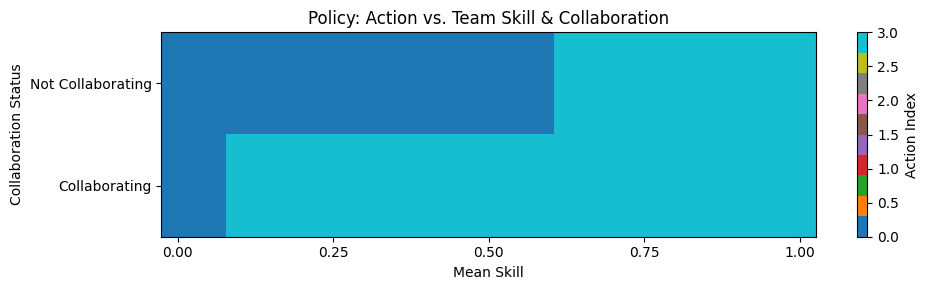

In [6]:
visualize_policy_heatmap(model, env)

In [7]:
def print_policy_for_all_states(policy_net, env):
    print("DQN Policy (Best Action per Explore State):")
    print("-" * 50)
    for explore_state in range(9):  # your explore_state space is 0–8
        fake_obs = {
            'explore_state': explore_state,
            'team_skills': [0.5] * env.team_size,
            'team_salaries': [0.5] * env.team_size,
            'candidate': [0.5, 0.5],
            'total_salary': float(env.team_size) * 0.5
        }
        flat_obs = flatten_observation(fake_obs)
        state_tensor = torch.tensor(flat_obs, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            q_values = policy_net(state_tensor)
            best_action = q_values.argmax(dim=1).item()

        print(f"Explore State {explore_state}: Best Action = {best_action}")


In [8]:
print_policy_for_all_states(model,env)

DQN Policy (Best Action per Explore State):
--------------------------------------------------
Explore State 0: Best Action = 3
Explore State 1: Best Action = 3
Explore State 2: Best Action = 0
Explore State 3: Best Action = 0
Explore State 4: Best Action = 0
Explore State 5: Best Action = 3
Explore State 6: Best Action = 5
Explore State 7: Best Action = 5
Explore State 8: Best Action = 5


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import BoundaryNorm

def run_and_plot_episode(policy_net, env):
    obs, _ = env.reset()
    done = False
    steps = 0

    skill_trace = []
    action_trace = []
    phase_trace = []
    collab_trace = []

    while not done:
        flat_obs = flatten_observation(obs)
        state = torch.tensor(flat_obs, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            action = policy_net(state).argmax(dim=1).item()

        # For tracking/debugging
        if action == 0:
            print(f"[DEBUG] Retreat action taken at step {steps}")

        # Extract values
        explore_state = obs['explore_state']
        is_collaborating = 1 if explore_state in [0, 1] else 0
        team_skill = np.mean(obs['team_skills']) if len(obs['team_skills']) > 0 else 0.0

        skill_trace.append(team_skill)
        action_trace.append(action)
        phase_trace.append(explore_state)
        collab_trace.append(is_collaborating)

        obs, reward, done, _, _ = env.step(action)
        steps += 1
        if steps > 1000:
            print("Episode cut off at 100 steps")
            break

    # Convert to arrays
    skill_trace = np.array(skill_trace)
    action_trace = np.array(action_trace)
    phase_trace = np.array(phase_trace)
    collab_trace = np.array(collab_trace)

    # --- Plot ---
    plt.figure(figsize=(12, 5))

    # Shade collaboration regions
    for i in range(len(collab_trace)):
        if collab_trace[i] == 1:
            plt.axvspan(i - 0.5, i + 0.5, color='blue', alpha=0.05)

    plt.plot(skill_trace, label="Mean Team Skill", linewidth=2)

    # Plot scatter for actions
    max_action = max(action_trace)
    num_actions = max(5, max_action + 1)  # Ensure we show at least 5 actions

    cmap = plt.get_cmap("tab10", num_actions)
    norm = BoundaryNorm(list(range(num_actions + 1)), cmap.N)

    sc = plt.scatter(range(len(action_trace)), skill_trace, c=action_trace, cmap=cmap, norm=norm, s=50)

    cbar = plt.colorbar(sc, ticks=range(num_actions))
    cbar_labels = ["Explore", "Retreat", "ToggleCollab", "Search"] + [f"Hire/Fire {i}" for i in range(num_actions - 4)]
    cbar.ax.set_yticklabels(cbar_labels[:num_actions])
    cbar.set_label("Action")

    # Phase end marker
    if phase_trace[-1] in [6, 7, 8]:  # AGI states
        plt.axvline(len(phase_trace) - 1, color="green", linestyle="--", label="AGI Found")
    elif phase_trace[-1] in [3, 4, 5]:  # Gave up
        plt.axvline(len(phase_trace) - 1, color="red", linestyle="--", label="Gave Up")

    plt.xlabel("Step")
    plt.ylabel("Mean Team Skill")
    plt.title("Episode Rollout: Skill, Actions, and Collaboration")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


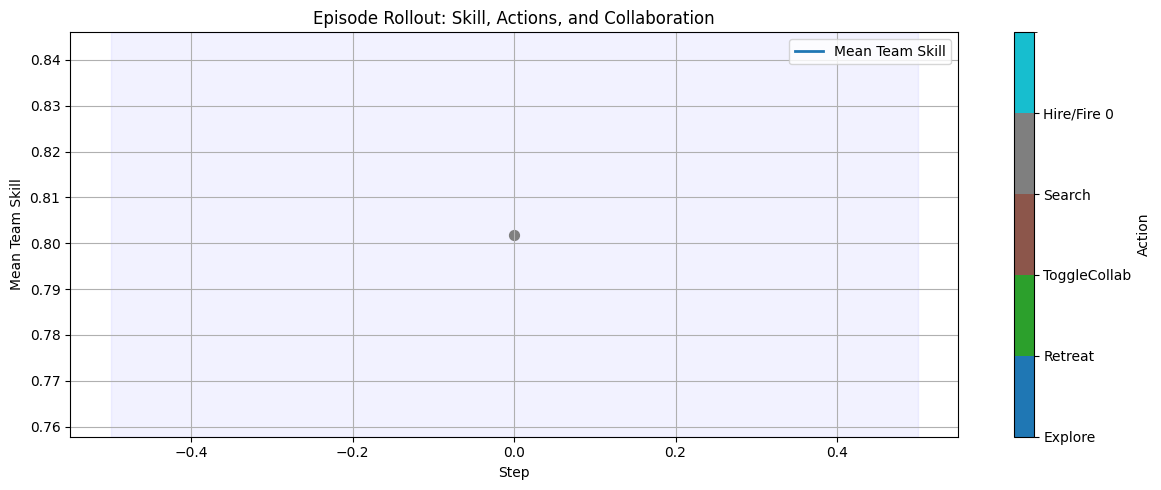

In [22]:
run_and_plot_episode(model, env)